## Prep
Run the following in ***two*** terminal

Scheduler
```bash
dask-scheduler
```
Workers
```bash
mkdir dask-work-dir;
dask-worker --nprocs 4 --nthreads 1 localhost:8786 --local-directory dask-work-dir
```

In [3]:
import warnings
warnings.filterwarnings('ignore')

import dask
import dask.bag as db
import dask.dataframe as dd
from dask.dot import dot_graph
from dask.diagnostics import ProgressBar
from dask.distributed import Client

In [6]:
dask_client = Client('localhost:8786')
dask_client

Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.58 GB


In [8]:
%matplotlib notebook

In [9]:
import pandas as pd
import re
import html
from datetime import datetime

In [10]:
tags = db.read_text('data/askubuntu.com/Tags.xml', encoding='utf-8')

In [11]:
tags.take(10)

('\ufeff<?xml version="1.0" encoding="utf-8"?>\n',
 '<tags>\n',
 '  <row Id="1" TagName="battery" Count="1124" ExcerptPostId="56974" WikiPostId="56973" />\n',
 '  <row Id="2" TagName="notification" Count="681" ExcerptPostId="60037" WikiPostId="60036" />\n',
 '  <row Id="4" TagName="software-center" Count="2444" ExcerptPostId="23972" WikiPostId="23971" />\n',
 '  <row Id="6" TagName="upgrade" Count="6820" ExcerptPostId="31700" WikiPostId="31699" />\n',
 '  <row Id="7" TagName="live-cd" Count="686" ExcerptPostId="33366" WikiPostId="33365" />\n',
 '  <row Id="8" TagName="server" Count="11609" ExcerptPostId="31533" WikiPostId="31532" />\n',
 '  <row Id="9" TagName="ssh" Count="4346" ExcerptPostId="31545" WikiPostId="31544" />\n',
 '  <row Id="10" TagName="vnc" Count="726" ExcerptPostId="57694" WikiPostId="57693" />\n')

In [12]:
tags_rows = tags.filter(lambda line: line.find('<row') >= 0)
tags_rows.take(5)

('  <row Id="1" TagName="battery" Count="1124" ExcerptPostId="56974" WikiPostId="56973" />\n',
 '  <row Id="2" TagName="notification" Count="681" ExcerptPostId="60037" WikiPostId="60036" />\n',
 '  <row Id="4" TagName="software-center" Count="2444" ExcerptPostId="23972" WikiPostId="23971" />\n',
 '  <row Id="6" TagName="upgrade" Count="6820" ExcerptPostId="31700" WikiPostId="31699" />\n',
 '  <row Id="7" TagName="live-cd" Count="686" ExcerptPostId="33366" WikiPostId="33365" />\n')

We need to define a function that exctract each field in a column with a data type

In [13]:
def extraction(line, col_name, col_type=str):
    regex = r'{}="([^"]*)"'.format(col_name)
    match = re.search(regex, line)
    # both float and str allow for None but not int, so set to 0
    null_val = 0 if col_type == int else None
    return col_type(match[1]) if match is not None else null_val

Let's testing the extraction function

In [14]:
test_line = tags_rows.take(5)[0]
test_line

'  <row Id="1" TagName="battery" Count="1124" ExcerptPostId="56974" WikiPostId="56973" />\n'

In [15]:
print(extraction(test_line, 'TagName'))

battery


In [16]:
print(extraction(test_line, 'Count', int))

1124


In [18]:
print(extraction(test_line, 'Unknown', int))

0


In [19]:
print(extraction(test_line, 'Unknown', str))

None


We need a function that create a data structure for each line

In [20]:
def extract_col(line):
    colrows = {
        'id': extraction(line, 'Id', int),
        'tag': extraction(line, 'TagName', str),
        'count': extraction(line, 'Count', int)
    }
    return colrows

Let's test it

In [21]:
extract_col(test_line)

{'id': 1, 'tag': 'battery', 'count': 1124}

In [22]:
ddf_tags = tags_rows.map(extract_col).to_dataframe()
ddf_tags

,count,id,tag
npartitions=1,,,
,int64,int64,object
,...,...,...


In [23]:
ddf_tags.npartitions

1

In [26]:
print(ddf_tags.dask)

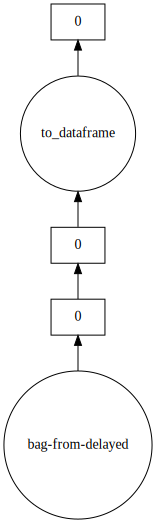

In [27]:
ddf_tags.visualize(filename='tags.svg')

In [28]:
%%time
dftags = ddf_tags.compute()
print(dftags)

      count    id                     tag
0      1124     1                 battery
1       681     2            notification
2      2444     4         software-center
3      6820     6                 upgrade
4       686     7                 live-cd
5     11609     8                  server
6      4346     9                     ssh
7       726    10                     vnc
8       160    11               community
9      1510    14                    xfce
10      786    15          remote-desktop
11     4934    16                 updates
12     1314    19                   flash
13     1880    20                  64-bit
14     1433    22          update-manager
15      583    23                  xrandr
16       90    25             displaylink
17     2656    26                   mouse
18     2112    29              filesystem
19     6943    30            installation
20     1943    31                   10.04
21      671    32                   panel
22      187    33                 

<IPython.core.display.Javascript object>


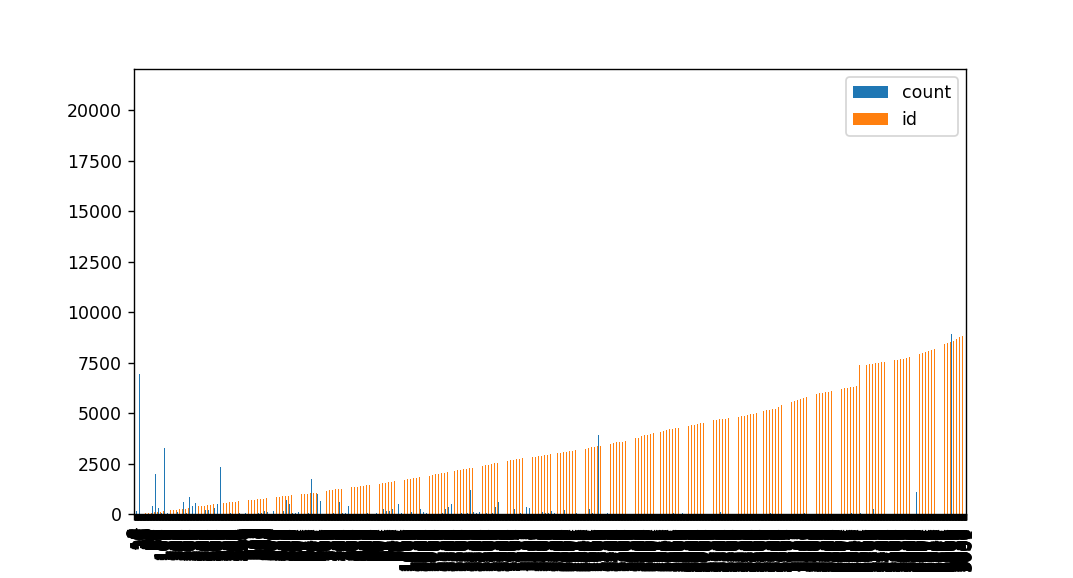

In [29]:
dftags.plot.bar()